# Inversion cheat sheet

This is a summary cheet sheet which combines the key principles into one easily accessible format for the purpose of revision and access during the class test.

# Table of contents
#### [Lecture 1: forward vs inverse problems, linear algebra](#lecture1)
#### [Lecture 2: ](#lecture2)
#### [Lecture 3: ](#lecture3)
#### [Lecture 4: ](#lecture4)
<hr/>

## Lecture 1: forward vs inverse problems, linear algebra <a name="lecture1"></a>

In STEM, we must pose many problems as inversion or optimsations problems. In the most general sense, inversion asks for some function 

$$y=f(x),$$

given $y$, what is $x$? This is contrary to the forward problem, which asks: given $x$, what is $y$? Thus, inversion problems can be formulated as 

$$f(x) = y,$$ 

or more commonly as 

$$A\mathbf{x}=\mathbf{b},$$ 

for a system of equations. Often, we choose to simplify our problem by approximating non-linear terms with linear functions. Then, it is important to remember that a linear function commutes with addition, i.e., 

$$f(\mathbf{x+y}) = f(\mathbf{x})+f(\mathbf{y}),$$
$$f(\alpha \mathbf{x})=\alpha f(\mathbf{x}), \ \alpha \in \mathbb{R}.$$

### Matrix properties

For some matrix $A$

$$\text{e.g.,} \ A = \begin{pmatrix} a & b \\ c&d \end{pmatrix}$$

the four basic matrix properties read that

$$(A+B)^T=A^T+B^T,$$ 

i.e., addition and transpose operations commute,

$$(\alpha A^T)=\alpha(A^T), \ \alpha \in \mathbb{R}$$

i.e., scalar multiplication and transpose operations commute,

$$(AB)^T = B^T A^T,$$

i.e., matrix multiplication and transpose operations commute, and finally

$$(A^T)^T = A.$$ 

Furthermore, we may say that 

$$A=A^T \Leftrightarrow \ A \ \text{is symmetric},$$
$$A=-A^T \Leftrightarrow \ A \ \text{is skew symmetric},$$

in which case 

$$A = \begin{pmatrix} 0 & b \\ -b&0 \end{pmatrix}.$$

This classification may be important later since the eigenvalues of a symmetric matrix are always real, and those of a skew symmetric matrix are always imaginary or zero. 

**We can implement checks of these properties as below**



In [2]:
import numpy as np

In [7]:
"Checking transpose properties"

# Define arbitrary dimensions
m = 3
n = 3

# Generate our random matrix
A = np.random.random((m, n))
B = np.random.random((m, n))

# Addition commutation (ABt = AtBt)
ABt = (A+B).T
AtBt = A.T + B.T
print(f'Addition commutes: {np.allclose(ABt, AtBt)}')

# Scalar multiplication ((aA)t = a(At))
alpha = 5

aAt = (alpha * A).T
a_At = alpha * (A.T)
print(f'Scalar multiplication commutes: {np.allclose(aAt, a_At)}')

# Matrix multiplication ((AB)t = AtBt)
ABt = (A@B).T
AtBt = B.T @ A.T
print(f'Matrix multiplication commutes: {np.allclose(ABt, AtBt)}')

# Double transpose
Att = (A.T).T
print(f'Double transpose: {np.allclose(Att, A)}')

Addition commutes: True
Scalar multiplication commutes: True
Matrix multiplication commutes: True
Double transpose: True


### Matirx-vector multiplication

It can be useful to think of vector-matrix multiplication as the weighted sum of the columns of the matrix. For the matrix $A, \ A \in \mathbb{R}^{m\times n}$ and vector $\mathbf{x}, \ \mathbf{x} \in \mathbb{R}^{n}$ in the system $A\mathbf{x}=\mathbf{b}, \ \mathbf{b} \in \mathbb{R}^m $ we can write 

$$\mathbf{b_i} = \sum^{n}_{j=1} a_{ij}x_j, \ i=1,\ 2, \dots,\ m,$$ 

which is equivalent to saying

$$A\mathbf{x} = [x_0 a_{:1}, \ x_1 a_{:2}, \dots,\ x_n a_{:m}],$$

which we can compute in the following manner.

In [ ]:
# Our function to execute matrix-vector mutliplication, as defined in the lecture

def mat_vec_product(A, x):
    m, n = np.shape(A)
    assert x.ndim == 1 # restrict to the case where x is 1D
    assert n == len(x) # as 1D we can check the length of x is consistent with A
    b = np.zeros(m) # and then initialise to zero the appropriate length array for b
    for i in range(m):
        for j in range(n):
            b[i] += A[i, j] * x[j]
    return b

In [10]:
# Defining our dimensions
m = 4
n = 4

# Let's define A and x
A = np.random.random((m, n))
x = np.random.random((n,))

# Executing the product using the function defined in the lecture
b = mat_vec_product(A, x)

# Computing the product directly 
Ax = A@x

# Checking similarity between two methods
np.allclose(b, Ax)

True

### Newton's method

We can often pose an inversion problem as a root finding problem by solving iteratively for $x_{i+1}$. If we have some function $f$, then we can find a root by setting $f(x)=0$ and solving for $x$. Newton's iterative solution method reads  

$$x_{i+1}=x_i - \frac{f(x_i)}{f'(x_i)}.$$

### Curve fitting

With a system of equations, often it is the case that there is no absolute solution vector which satisfies all constraints posed by the equations in the model. In this case, our inversion problem becomes an optimisation problem. The least squares solution minimises the square difference between a function evaluated at a guess location $x_i$ and the given data points. The error $E$ can be defined as

$$||A\mathbf{x}-\mathbf{y}||^2_2.$$ 

It will be shown later that the least squares solution to the system $A\mathbf{x}=\mathbf{b}$ is found by solving

$$A^TA\mathbf{x}=V^T\mathbf{y},$$

which holds for under determined problems. We can approximate a polynomial for a given set of data in the following manner.

In [11]:
import matplotlib.pyplot as plt


poly_coeffs = 
 [-0.00552147  0.09889271 -0.43193108  0.75909819]


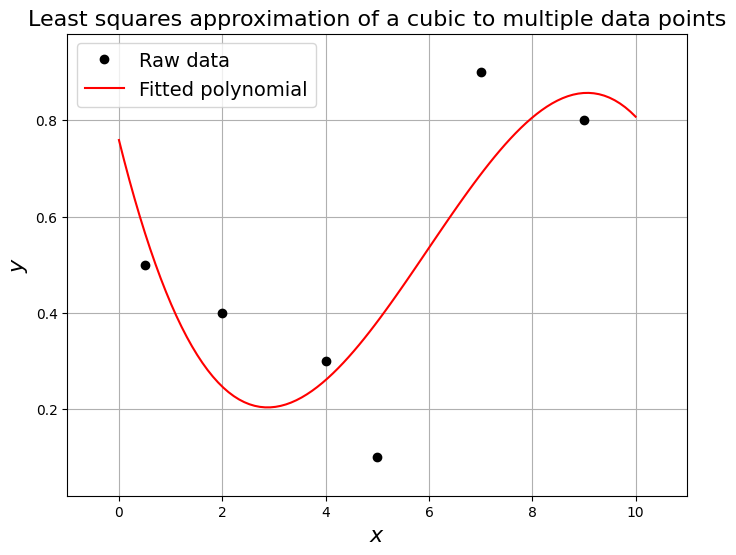

In [18]:
# Our data from Lecture 1:
x = np.array([0.5, 2.0, 4.0, 5.0, 7.0, 9.0])
y = np.array([0.5, 0.4, 0.3, 0.1, 0.9, 0.8])

# Consider a polynomial of degree 3 - so not high enough to go through all the data
N = 3

# Compare against the coefficient that numpy's polyfit gives us
poly_coeffs = np.polyfit(x, y, N)
print('\npoly_coeffs = \n', poly_coeffs)

xx = np.linspace(0, 10, 100) # To generate smooth curve

# Evaluate the polynomial at the given x values
y_poly = np.polyval(poly_coeffs, xx)

# set up figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

# Overlay raw data
ax1.plot(x, y, 'ko', label='Raw data')
ax1.plot(xx, y_poly, 'r-', label='Fitted polynomial')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Least squares approximation of a cubic to multiple data points', fontsize=16)
ax1.grid(True)
ax1.legend(loc='best', fontsize=14);

## Lecture 2: <a name="lecture2"></a>

## Lecture 3: <a name="lecture3"></a>

We can often pose an inversion problem as a root finding problem by solving iteratively for $x_{i+1}$. If we have some function $f$, then we can find a root by setting $f(x)=0$ and solving for $x$. Then, in a similar way, if we have $g(x)=f'(x)$ then the $x$ for which $g(x)=0$ are minimum solutions to the problem. By posing the problem in this manner it becomes a minimsiation problem and we can apply Newton's method as

$$x_{i+1}=x_i - \frac{g(x_i)}{g'(x_i)}$$

## Lecture 4: <a name="lecture4"></a>